<a href="https://www.kaggle.com/code/gregoriusbayuaji/top-restaurants-business-analysis?scriptVersionId=203847654" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [127]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/restaurant-business-rankings-2020/Top250.csv
/kaggle/input/restaurant-business-rankings-2020/Future50.csv
/kaggle/input/restaurant-business-rankings-2020/Independence100.csv


The first thing we need to do is to call the table.

In [128]:
top_resto = pd.read_csv("../input/restaurant-business-rankings-2020/Top250.csv")


From the call above, we get this table.

In [129]:
top_resto.head()

,Rank,Restaurant,Content,Sales,YOY_Sales,Units,YOY_Units,Headquarters,Segment_Category
0,1,McDonald's,NaN,40412,4.9%,13846,-0.5%,NaN,Quick Service & Burger
1,2,Starbucks,NaN,21380,8.6%,15049,3.0%,NaN,Quick Service & Coffee Cafe
2,3,Chick-fil-A,While Popeyes got a lot of the chicken buzz in...,11320,13.0%,2470,5.0%,NaN,Quick Service & Chicken
3,4,Taco Bell,NaN,11293,9.0%,6766,2.7%,NaN,Quick Service & Mexican
4,5,Burger King,NaN,10204,2.7%,7346,0.2%,NaN,Quick Service & Burger


# Restaurant Conditions

In [130]:
top_resto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Rank              250 non-null    int64 
 1   Restaurant        250 non-null    object
 2   Content           33 non-null     object
 3   Sales             250 non-null    int64 
 4   YOY_Sales         250 non-null    object
 5   Units             250 non-null    int64 
 6   YOY_Units         250 non-null    object
 7   Headquarters      52 non-null     object
 8   Segment_Category  250 non-null    object
dtypes: int64(3), object(6)
memory usage: 17.7+ KB


- Restaurant: Name of the Restaurant
- Content: Description, only for certain restaurants
- Sales: In Million USD
- YOY_Sales: Year-on-Year Sale Growth in %
- Units: Number of premises in US
- YOY_Units: Year-on-Year Premise Growth in %
- Headquarters: Place of the restaurant Headquarters
- Segment_Category: Menu type and/or industry segment

# Data Preparation

## Content & Headquarters Classification

Some of the data don't have content or headquarter places. We need to create new column to classify if the restaurant create the advertisement content and headquarters or not

In [131]:
# Create a new column that classifies if a row has a value in 'column_name'
top_resto['Adv Content Exist (1 = Yes, 0 = No)'] = top_resto['Content'].apply(lambda x: 1 if pd.notnull(x) and x != '' else 0)
top_resto['Headquarters Exist (1 = Yes, 0 = No)'] = top_resto['Headquarters'].apply(lambda x: 1 if pd.notnull(x) and x != '' else 0)

## Segment_Category Check

In [132]:
top_resto['Segment_Category'].value_counts().sort_index()

Asian                               3
Asian/Noodle                        3
BBQ                                 7
Bakery Cafe                         8
Burger                             10
Casual Dining & Asian               1
Casual Dining & Italian/Pizza       4
Casual Dining & Seafood             2
Casual Dining & Sports Bar          3
Casual Dining & Steak               4
Casual Dining & Varied Menu         9
Chicken                             7
Coffee Cafe                         4
Ethnic                              1
Family Casual                       4
Family Dining & Family Style        7
Family Style                       10
Fast Casual & Asian/Noodle          2
Fast Casual & Bakery Cafe           1
Fast Casual & Burger                4
Fast Casual & Chicken               4
Fast Casual & Mexican               3
Fast Casual & Pizza                 1
Fast Casual & Sandwich              6
Fine Dining & Steak                 1
Frozen Desserts                     4
Healthy     

From the data above we can see some restaurant has other type of 'Service type' such as 'Quick Service', 'Fast Casual', and 'Casual Dining'. We need to split this service type because it may have effect to the restaurant's performance number

In [133]:
# Create the 'Category' column based on 'Fast Casual', 'Casual Dining', or 'Quick Service'
top_resto['Category'] = top_resto['Segment_Category'].apply(
    lambda x: 'Fast Casual' if 'Fast Casual' in x 
    else ('Casual Dining' if 'Casual Dining' in x 
    else ('Quick Service' if 'Quick Service' in x else np.nan))
)

# Remove 'Fast Casual', 'Casual Dining', and 'Quick Service' from the 'Segment_Category' and rename it to 'Menu_Type'
top_resto['Segment'] = top_resto['Segment_Category'].str.replace('Fast Casual &', '', regex=False)\
                                                      .str.replace('Casual Dining &', '', regex=False)\
                                                      .str.replace('Quick Service &', '', regex=False)\
                                                      .str.strip()  # Remove any leading/trailing spaces

# Drop the old 'Segment_Category' column if not needed
top_resto = top_resto.drop('Segment_Category', axis=1)

top_resto['Segment'].value_counts().sort_index()

Asian                            4
Asian/Noodle                     5
BBQ                              7
Bakery Cafe                     10
Beverage                         3
Burger                          27
Chicken                         17
Coffee Cafe                      8
Ethnic                           1
Family Casual                    5
Family Dining & Family Style     7
Family Style                    10
Fine Dining & Steak              1
Frozen Desserts                  6
Healthy                          1
Italian/Pizza                   14
Mexican                         19
Pizza                           18
Sandwich                        17
Seafood                         11
Snack                            6
Sports Bar                       9
Steak                           13
Varied Menu                     31
Name: Segment, dtype: int64

Now we have 24 segments of restaurant

In [186]:
top_resto['Category'].value_counts().sort_index()

Casual Dining    23
Fast Casual      21
Quick Service    47
Name: Category, dtype: int64

and 3 categories of restaurant

## YOY Column Format

Based on 'info' list above, the year-on-year sales and units percentage are still not at the float format. To make it easier for us to analyze the progress of each restaurant. We need to format them to a float.

In [134]:
# Create new column that contains only the integer data of year-on-year sales & units
top_resto['YOY_Sales (%)'] = top_resto['YOY_Sales'].apply(lambda x: float(float(x.strip('%'))))
top_resto['YOY_Units (%)'] = top_resto['YOY_Units'].apply(lambda x: float(float(x.strip('%'))))

# Drop the original column of YOY_sales and YOY_units
top_resto = top_resto.drop(columns=['YOY_Sales', 'YOY_Units'])

## Rename Column

Some numerical columns have no unit description at their column names. So, we need to add the unit description to make it easier for us to analyze the performance

In [135]:
# Rename the 'Sales' column into 'Sales (Million USD)'
top_resto = top_resto.rename(columns={'Sales': 'Sales (Million USD)', 'Units': 'Units (pcs)'})

This is the final info and description of the data

In [136]:
top_resto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Rank                                  250 non-null    int64  
 1   Restaurant                            250 non-null    object 
 2   Content                               33 non-null     object 
 3   Sales (Million USD)                   250 non-null    int64  
 4   Units (pcs)                           250 non-null    int64  
 5   Headquarters                          52 non-null     object 
 6   Adv Content Exist (1 = Yes, 0 = No)   250 non-null    int64  
 7   Headquarters Exist (1 = Yes, 0 = No)  250 non-null    int64  
 8   Category                              91 non-null     object 
 9   Segment                               250 non-null    object 
 10  YOY_Sales (%)                         250 non-null    float64
 11  YOY_Units (%)      

In [137]:
top_resto.describe()

,Rank,Sales (Million USD),Units (pcs),"Adv Content Exist (1 = Yes, 0 = No)","Headquarters Exist (1 = Yes, 0 = No)",YOY_Sales (%),YOY_Units (%)
count,250.000000,250.00000,250.000000,250.00000,250.000000,250.000000,250.000000
mean,125.500000,1242.74000,850.076000,0.13200,0.208000,2.938400,1.219200
std,72.312977,3365.22882,2296.151659,0.33917,0.406691,8.953784,7.936431
min,1.000000,126.00000,13.000000,0.00000,0.000000,-21.200000,-32.800000
25%,63.250000,181.00000,85.000000,0.00000,0.000000,-2.375000,-2.025000
50%,125.500000,330.00000,207.000000,0.00000,0.000000,2.200000,0.000000
75%,187.750000,724.75000,555.250000,0.00000,0.000000,6.575000,3.475000
max,250.000000,40412.00000,23801.000000,1.00000,1.000000,39.500000,38.500000


From the description above we can see that the sale rate and unit number of each restaurant have high standard deviation value. We can also see that the minimum value of those rate are only 126 Million USD of sales and only 13 units, but the maximum value can reach 40 Billion USD of sales and almost 24 thousand units. From year-on-year percentage we can also see that with the q2 value that reach zero, it can be concluded that there is a balancing number of negative and positive year-on-year sales or units.

# Restaurant Data Analysis

## Sales

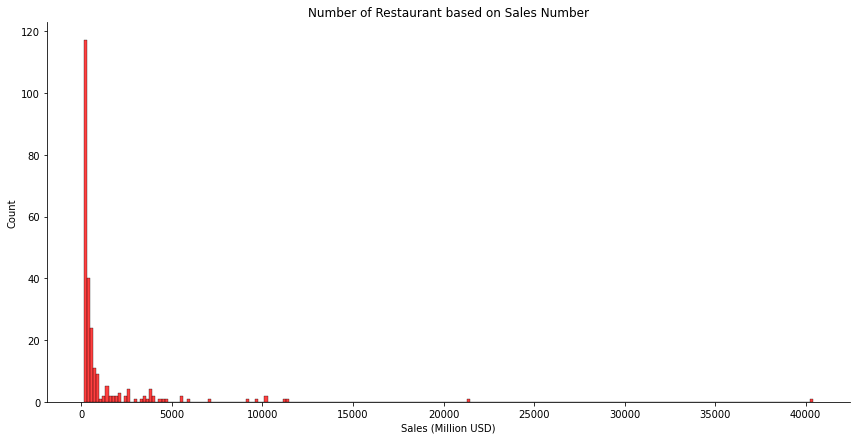

In [138]:
sns.displot(top_resto['Sales (Million USD)'], height=6, aspect=2, color='Red').set(title='Number of Restaurant based on Sales Number')

From the plot above we can see that almost all of the restaurants reach the sales rate of less than 5 Billion USD a year. But there are 2 restaurants that reach more than 20 Billion USD sale rate this year. 

In [187]:
sales_high = top_resto.nlargest(n=15, columns='Sales (Million USD)').sort_values('Sales (Million USD)', ascending=False)
sales_high = sales_high[['Restaurant', 'Category', 'Segment', 'Sales (Million USD)']]
print("Top 15 Highest Sale rate restaurant")
print(sales_high)

Top 10 Highest Sale rate restaurant
                Restaurant       Category        Segment  Sales (Million USD)
0               McDonald's  Quick Service         Burger                40412
1                Starbucks  Quick Service    Coffee Cafe                21380
2              Chick-fil-A  Quick Service        Chicken                11320
3                Taco Bell  Quick Service        Mexican                11293
4              Burger King  Quick Service         Burger                10204
5                   Subway  Quick Service       Sandwich                10200
6                  Wendy's  Quick Service         Burger                 9762
7                  Dunkin'  Quick Service    Coffee Cafe                 9228
8                 Domino's  Quick Service          Pizza                 7044
9             Panera Bread    Fast Casual    Bakery Cafe                 5890
10               Pizza Hut  Quick Service          Pizza                 5558
11  Chipotle Mexican Grill  

Almost all of the top 10 highest sale rate restaurant are quick service restaurant, with 'burger' as the most dominant segment with 3 burger restaurant

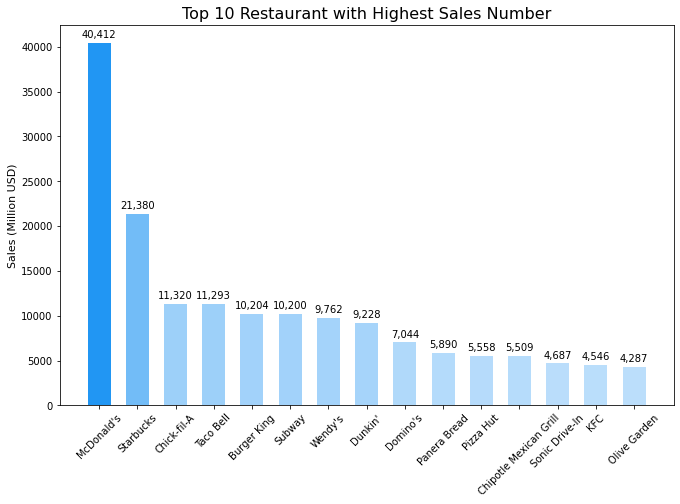

In [188]:
plt.figure(figsize = (11,7))

#Colours - Choose the extreme colours of the colour map
colours = ["#bbdefb", "#2196f3"]

# Colormap - Build the colour maps
cmap = mpl.colors.LinearSegmentedColormap.from_list('color map', colours, N=256)

# linearly normalizes data into the [0.0, 1.0] interval
norm = mpl.colors.Normalize(sales_high['Sales (Million USD)'].min(), sales_high['Sales (Million USD)'].max()) 

# Plot bars
bar = plt.bar(sales_high['Restaurant'], sales_high['Sales (Million USD)'], width=0.6, 
               color=cmap(norm(sales_high['Sales (Million USD)'])), zorder=2) 

# Add label on top of each bar
plt.bar_label(bar, padding=3, labels=[f'{e:,.0f}' for e in sales_high['Sales (Million USD)']]) 
plt.title('Top 15 Restaurant with Highest Sales Number', size=16)
plt.xticks(rotation=45)


plt.ylabel('Sales (Million USD)', size=11)
plt.show()

From the graph above we can see that McDonald's is dominating with the sales value almost 2x of starbucks and 4x of Chick-fil-A. It really is a domination. Meanwhile we can see that beside McDonald's and Starbucks, there are no more restaurant with sale rate higher than 12 Billion USD.

In [194]:
sales_low = top_resto.nsmallest(n=10, columns='Sales (Million USD)').sort_values('Sales (Million USD)', ascending=False)
sales_low = sales_low[['Restaurant', 'Category', 'Segment', 'Sales (Million USD)']]
print("Top 10 Lowest Sale rate restaurant")
sales_low

Top 10 Lowest Sale rate restaurant


,Restaurant,Category,Segment,Sales (Million USD)
240,54th Street Restaurant & Drafthouse,NaN,Varied Menu,131
241,Biggby Coffee,NaN,Coffee Cafe,129
242,Costa Vida Fresh Mexican Grill,NaN,Mexican,129
243,L&L Hawaiian Barbecue,NaN,BBQ,129
244,Gyu-Kaku,NaN,Asian,129
245,Rainforest Cafe,NaN,Varied Menu,129
246,PDQ,NaN,Chicken,127
247,Lupe Tortilla,NaN,Mexican,127
248,Cook-Out Restaurant,NaN,Burger,126
249,Jollibee,NaN,Chicken,126


Meanwhile, The top 10 lowest sale rate restaurant showed that there are no restaurant with the sale rate higher than 150 million USD, and none of them makes a service-based category

## Unit

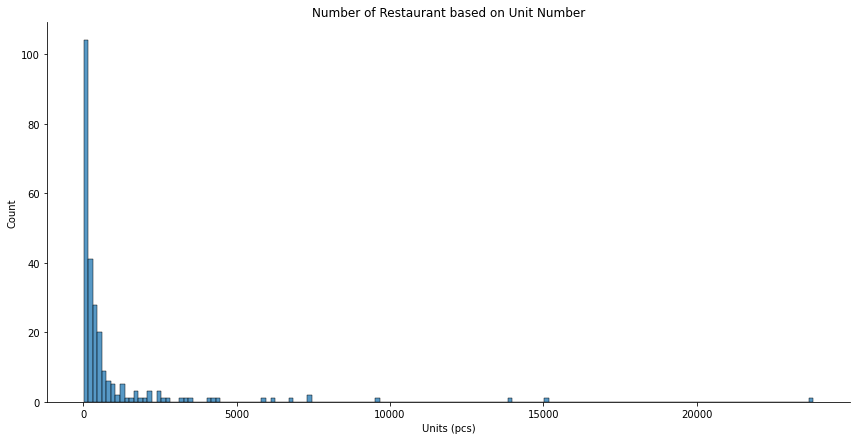

In [142]:
sns.displot(top_resto['Units (pcs)'], height=6, aspect=2).set(title='Number of Restaurant based on Unit Number')

Top Restaurant are the restaurant that already known by the people. From the graph below we can see that a lot of them has less than 5.000 units. But the largest has more than 20.000 units 

In [190]:
unit_high = top_resto.nlargest(n=15, columns='Units (pcs)').sort_values('Units (pcs)', ascending=False)
unit_high = unit_high[['Restaurant','Category', 'Segment', 'Units (pcs)']]
print("Top 15 Highest Unit number restaurant")
print(unit_high)

Top 15 Highest Unit number restaurant
        Restaurant       Category          Segment  Units (pcs)
5           Subway  Quick Service         Sandwich        23801
1        Starbucks  Quick Service      Coffee Cafe        15049
0       McDonald's  Quick Service           Burger        13846
7          Dunkin'  Quick Service      Coffee Cafe         9630
4      Burger King  Quick Service           Burger         7346
10       Pizza Hut  Quick Service            Pizza         7306
3        Taco Bell  Quick Service          Mexican         6766
8         Domino's  Quick Service            Pizza         6126
6          Wendy's  Quick Service           Burger         5852
20     Dairy Queen  Quick Service  Frozen Desserts         4381
19  Little Caesars  Quick Service            Pizza         4237
13             KFC  Quick Service          Chicken         4065
12  Sonic Drive-In  Quick Service           Burger         3526
17          Arby's  Quick Service         Sandwich         3359
27

From the table above we can see that all top 15 resto with the most units are Quick Service Restaurants and only 9 of them has more than 5000 units. The segment is dominated by Pizza, Burger, and Cafe segments.

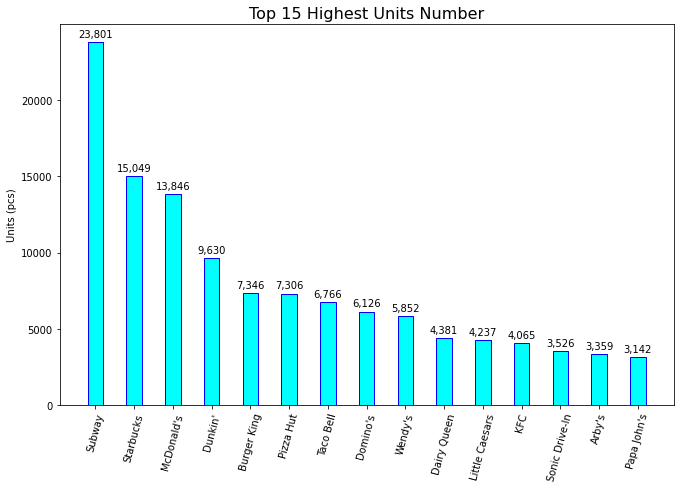

In [192]:
plt.figure(figsize=(11,7))
bar = plt.bar(unit_high['Restaurant'], unit_high['Units (pcs)'], width=0.4, color='cyan',edgecolor='blue')
plt.bar_label(bar, padding=3, labels=[f'{e:,.0f}' for e in unit_high['Units (pcs)']]) 
plt.title('Top 15 Highest Units Number', size=16)
plt.xticks(rotation=75)
plt.ylabel('Units (pcs)')
plt.show()

McDonald's isn't dominating here. Surprisingly, Subway has the most units here, even though they don't even reach the top 15 sales rate. How could that happen? We will see by other variable

In [206]:
units_low = top_resto.nsmallest(n=10, columns='Units (pcs)').sort_values('Units (pcs)', ascending=False)
units_low = units_low[['Restaurant', 'Category', 'Segment', 'Units (pcs)']]
print("Top 10 Lowest Unit rate restaurant")
print(units_low)

Top 10 Lowest Unit rate restaurant
                                Restaurant Category      Segment  Units (pcs)
187                  Bubba Gump Shrimp Co.      NaN      Seafood           27
227                    Pappasito's Cantina      NaN      Mexican           25
247                          Lupe Tortilla      NaN      Mexican           25
224                Eddie V's Prime Seafood      NaN      Seafood           21
154                   Mastro's Restaurants      NaN        Steak           18
245                        Rainforest Cafe      NaN  Varied Menu           18
232                                   Nobu      NaN        Asian           17
168  Del Frisco's Double Eagle Steak House      NaN        Steak           16
226                            Ocean Prime      NaN      Seafood           16
212                         Grand Lux Cafe      NaN  Varied Menu           13


It has almost the same condition with the top 10 lowest sale rate restaurant that none of them specialised their service category

## Sales per Units

In [146]:
sales_per_units = (top_resto['Sales (Million USD)'] / top_resto['Units (pcs)']).round(2)
top_resto['Sales per Units (Million USD)'] = sales_per_units
top_resto

,Rank,Restaurant,Content,Sales (Million USD),Units (pcs),Headquarters,"Adv Content Exist (1 = Yes, 0 = No)","Headquarters Exist (1 = Yes, 0 = No)",Category,Segment,YOY_Sales (%),YOY_Units (%),Sales per Units (Million USD)
0,1,McDonald's,NaN,40412,13846,NaN,0,0,Quick Service,Burger,4.9,-0.5,2.92
1,2,Starbucks,NaN,21380,15049,NaN,0,0,Quick Service,Coffee Cafe,8.6,3.0,1.42
2,3,Chick-fil-A,While Popeyes got a lot of the chicken buzz in...,11320,2470,NaN,1,0,Quick Service,Chicken,13.0,5.0,4.58
3,4,Taco Bell,NaN,11293,6766,NaN,0,0,Quick Service,Mexican,9.0,2.7,1.67
4,5,Burger King,NaN,10204,7346,NaN,0,0,Quick Service,Burger,2.7,0.2,1.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,246,Rainforest Cafe,NaN,129,18,NaN,0,0,NaN,Varied Menu,-10.4,-5.3,7.17
246,247,PDQ,NaN,127,56,NaN,0,0,NaN,Chicken,-5.5,-11.1,2.27
247,248,Lupe Tortilla,NaN,127,25,NaN,0,0,NaN,Mexican,12.1,8.7,5.08
248,249,Cook-Out Restaurant,NaN,126,270,NaN,0,0,NaN,Burger,10.1,7.1,0.47


To know the effectiveness of the sale value of each unit, we need to see how much each units produced sale value to the restaurant.

In [196]:
sales_per_unit_high = top_resto.nlargest(n=15, columns='Sales per Units (Million USD)').sort_values('Sales per Units (Million USD)', ascending=False)
sales_per_unit_high = sales_per_unit_high[['Restaurant','Category', 'Segment', 'Sales per Units (Million USD)']]
print("Top 10 Highest Sales per Unit rate restaurant")
sales_per_unit_high

Top 10 Highest Sales per Unit rate restaurant


,Restaurant,Category,Segment,Sales per Units (Million USD)
154,Mastro's Restaurants,NaN,Steak,13.44
168,Del Frisco's Double Eagle Steak House,NaN,Steak,12.81
212,Grand Lux Cafe,NaN,Varied Menu,12.08
32,The Cheesecake Factory,Casual Dining,Varied Menu,10.58
226,Ocean Prime,NaN,Seafood,9.00
119,Cooper's Hawk Winery & Restaurants,NaN,Varied Menu,8.24
232,Nobu,NaN,Asian,8.18
88,Portillo's,Fast Casual,Sandwich,8.15
95,The Capital Grille,NaN,Fine Dining & Steak,7.95
104,Maggiano's Little Italy,NaN,Italian/Pizza,7.87


From the list above we can see that no restaurant from our early top 15 list are in that list. This list is filled by restaurant with high price and high quality, so each unit will produce more sales. But, most of that type of restaurant don't create much units. That's why this list has different value

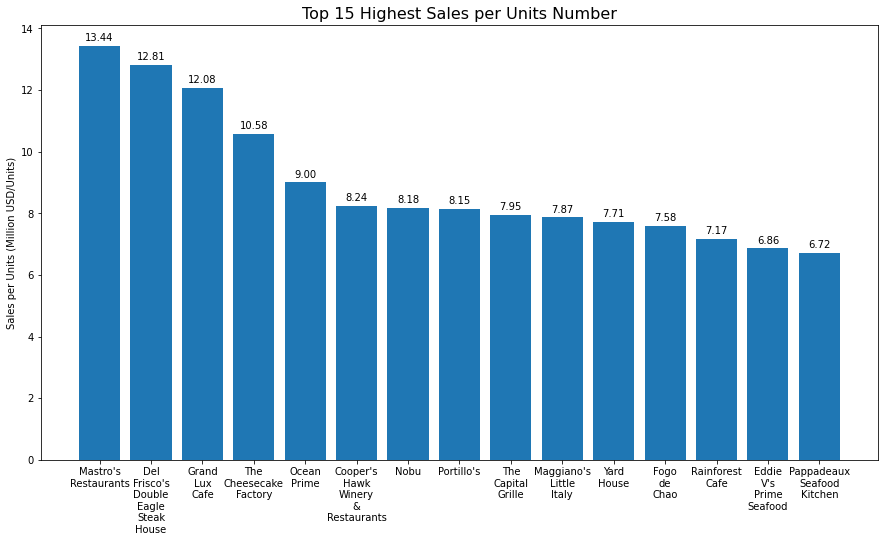

In [205]:
# Split labels into multiple lines by inserting '\n' where appropriate.
restaurants = [label.replace(" ", "\n") for label in sales_per_unit_high['Restaurant']]

plt.figure(figsize=(15, 8))
bar = plt.bar(restaurants, sales_per_unit_high['Sales per Units (Million USD)'])
plt.bar_label(bar, padding=3, labels=[f'{e:,.2f}' for e in sales_per_unit_high['Sales per Units (Million USD)']]) 

plt.xticks(rotation=0)  # No rotation necessary with multi-line labels
plt.title('Top 15 Highest Sales per Units Number', size=16)
plt.ylabel('Sales per Units (Million USD/Units)')
plt.show()

In [195]:
sales_per_unit_low = top_resto.nsmallest(n=10, columns='Sales per Units (Million USD)').sort_values('Sales per Units (Million USD)', ascending=False)
sales_per_unit_low = sales_per_unit_low[['Restaurant','Category', 'Segment', 'Sales per Units (Million USD)']]
print("Top 10 Lowest Sales per Unit rate restaurant")
sales_per_unit_low

Top 10 Lowest Sales per Unit rate restaurant


,Restaurant,Category,Segment,Sales per Units (Million USD)
152,Godfather's Pizza,NaN,Pizza,0.44
5,Subway,Quick Service,Sandwich,0.43
80,Auntie Anne's,Quick Service,Snack,0.43
111,Cold Stone Creamery,NaN,Frozen Desserts,0.41
159,A&W All-American Food,NaN,Burger,0.39
231,Great American Cookies,NaN,Snack,0.39
220,Menchie's Frozen Yogurt,NaN,Frozen Desserts,0.36
238,Daylight Donuts,NaN,Snack,0.32
72,Baskin-Robbins,Quick Service,Frozen Desserts,0.24
170,Cinnabon,NaN,Snack,0.21


From this list, you can see the reason why Subway are not at the top 15 list of restaurant with highest sale number. Because their units create low number of sales. Only 430 Thousand USD this year. They need to find more way to raise their sale value in their units.

## Segment

In [150]:
top_resto['Segment'].value_counts()

Varied Menu                     31
Burger                          27
Mexican                         19
Pizza                           18
Chicken                         17
Sandwich                        17
Italian/Pizza                   14
Steak                           13
Seafood                         11
Bakery Cafe                     10
Family Style                    10
Sports Bar                       9
Coffee Cafe                      8
BBQ                              7
Family Dining & Family Style     7
Snack                            6
Frozen Desserts                  6
Family Casual                    5
Asian/Noodle                     5
Asian                            4
Beverage                         3
Fine Dining & Steak              1
Healthy                          1
Ethnic                           1
Name: Segment, dtype: int64

From that 24 segments, we'll try to find the top 10 segments with highest sale value, unit number, and sale per units value.

In [151]:
top_resto.groupby('Segment')['Sales (Million USD)'].mean().round().sort_values(ascending=False).head(10)

Segment
Coffee Cafe                     4102.0
Burger                          3144.0
Chicken                         1715.0
Family Dining & Family Style    1668.0
Pizza                           1355.0
Sandwich                        1349.0
Mexican                         1195.0
Asian/Noodle                    1032.0
Frozen Desserts                  882.0
Steak                            846.0
Name: Sales (Million USD), dtype: float64

In [152]:
top_resto.groupby('Segment')['Units (pcs)'].mean().round().sort_values(ascending=False).head(10)

Segment
Coffee Cafe                     3396.0
Sandwich                        2150.0
Burger                          1622.0
Pizza                           1534.0
Frozen Desserts                 1461.0
Family Dining & Family Style    1007.0
Chicken                          886.0
Beverage                         858.0
Mexican                          695.0
Asian/Noodle                     646.0
Name: Units (pcs), dtype: float64

In [153]:
top_resto.groupby('Segment')['Sales per Units (Million USD)'].mean().round(2).sort_values(ascending=False).head(10)

Segment
Fine Dining & Steak    7.95
Steak                  5.98
Asian                  4.90
Seafood                4.70
Varied Menu            4.53
Sports Bar             3.39
Italian/Pizza          3.27
Family Casual          2.66
Mexican                2.45
Chicken                1.90
Name: Sales per Units (Million USD), dtype: float64

## Category

In [154]:
top_resto['Category'].value_counts().sort_values(ascending=False)

Quick Service    47
Casual Dining    23
Fast Casual      21
Name: Category, dtype: int64

In [155]:
top_resto.groupby('Category')['Sales (Million USD)'].mean().round(2).sort_values(ascending=False)

Category
Quick Service    4096.02
Casual Dining    1682.13
Fast Casual      1557.10
Name: Sales (Million USD), dtype: float64

In [156]:
top_resto.groupby('Category')['Units (pcs)'].mean().round(2).sort_values(ascending=False)

Category
Quick Service    3162.32
Fast Casual       996.24
Casual Dining     486.83
Name: Units (pcs), dtype: float64

In [157]:
top_resto.groupby('Category')['Sales per Units (Million USD)'].mean().round(2).sort_values(ascending=False)

Category
Casual Dining    3.91
Fast Casual      1.96
Quick Service    1.37
Name: Sales per Units (Million USD), dtype: float64

## Advertisement

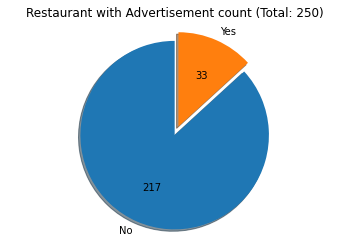

In [158]:
# Count the occurrences of each category
count = top_resto['Adv Content Exist (1 = Yes, 0 = No)'].value_counts()
labels = ['Yes' if label == 1 else 'No' for label in count.index]  # Map the labels

# Create the pie chart
plt.figure(figsize=(6, 4))

# Function to display the count in the pie chart
def func(pct, allvalues):
    absolute = int(round(pct / 100. * sum(allvalues)))
    return f"{absolute}"

plt.pie(count, labels=labels, explode=(0, 0.1), 
        autopct=lambda pct: func(pct, count), shadow=True, startangle=90)
plt.title('Restaurant with Advertisement count (Total: 250)')
plt.axis('equal')
plt.show()

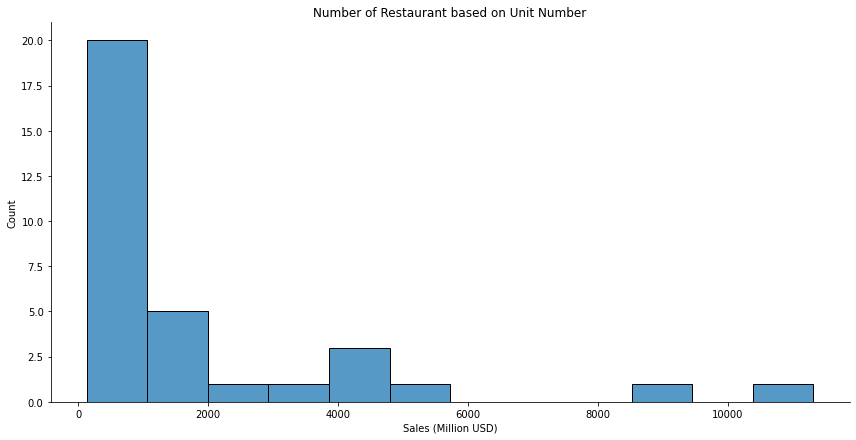

In [159]:
sns.displot(top_resto[top_resto['Adv Content Exist (1 = Yes, 0 = No)'] == 1]['Sales (Million USD)'], height=6, aspect=2).set(title='Number of Restaurant based on Unit Number')

In [160]:
top_resto[top_resto['Adv Content Exist (1 = Yes, 0 = No)'] == 1].nlargest(10, 'Sales (Million USD)')[['Restaurant', 'Sales (Million USD)']]

,Restaurant,Sales (Million USD)
2,Chick-fil-A,11320
7,Dunkin',9228
10,Pizza Hut,5558
12,Sonic Drive-In,4687
14,Olive Garden,4287
16,Panda Express,3946
19,Little Caesars,3811
31,Cracker Barrel,2482
37,Culver's,1795
40,Red Robin Gourmet Burgers and Brews,1548


In [161]:
top_resto[top_resto['Adv Content Exist (1 = Yes, 0 = No)'] == 0].nlargest(10, 'Sales (Million USD)')[['Restaurant', 'Sales (Million USD)']]

,Restaurant,Sales (Million USD)
0,McDonald's,40412
1,Starbucks,21380
3,Taco Bell,11293
4,Burger King,10204
5,Subway,10200
6,Wendy's,9762
8,Domino's,7044
9,Panera Bread,5890
11,Chipotle Mexican Grill,5509
13,KFC,4546


## Headquarters

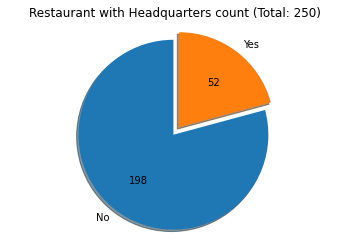

In [162]:
# Count the occurrences of each category
count = top_resto['Headquarters Exist (1 = Yes, 0 = No)'].value_counts()
labels = ['Yes' if label == 1 else 'No' for label in count.index]  # Map the labels

# Create the pie chart
plt.figure(figsize=(6, 4))

# Function to display the count in the pie chart
def func(pct, allvalues):
    absolute = int(round(pct / 100. * sum(allvalues)))
    return f"{absolute}"

plt.pie(count, labels=labels, explode=(0, 0.1), 
        autopct=lambda pct: func(pct, count), shadow=True, startangle=90)
plt.title('Restaurant with Headquarters count (Total: 250)')
plt.axis('equal')
plt.show()

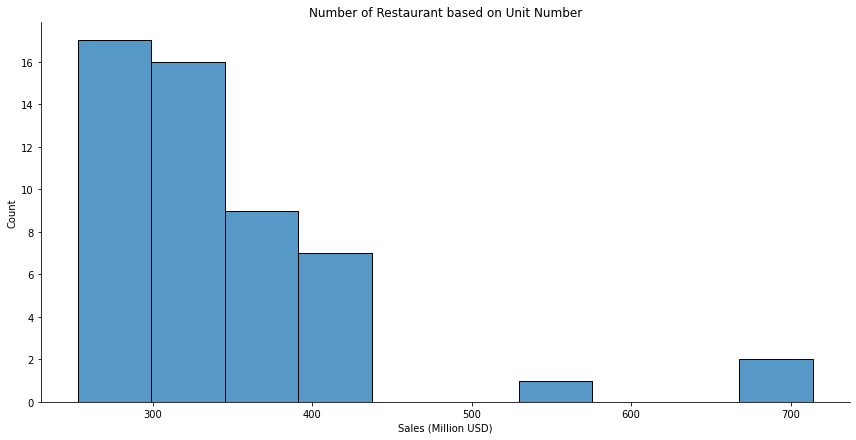

In [163]:
sns.displot(top_resto[top_resto['Headquarters Exist (1 = Yes, 0 = No)'] == 1]['Sales (Million USD)'], height=6, aspect=2).set(title='Number of Restaurant based on Unit Number')

In [164]:
top_resto[top_resto['Headquarters Exist (1 = Yes, 0 = No)'] == 1].nlargest(10, 'Sales (Million USD)')[['Restaurant', 'Sales (Million USD)']]

,Restaurant,Sales (Million USD)
65,Tim Hortons,714
66,Ruth's Chris Steak House,703
77,Dave & Buster's,571
101,Chuy's,426
102,O'Charley's,426
103,Pollo Tropical,425
104,Maggiano's Little Italy,417
105,Cicis,410
106,Long John Silver's,404
107,Saltgrass Steak House,402


In [165]:
top_resto[top_resto['Headquarters Exist (1 = Yes, 0 = No)'] == 0].nlargest(10, 'Sales (Million USD)')[['Restaurant', 'Sales (Million USD)']]

,Restaurant,Sales (Million USD)
0,McDonald's,40412
1,Starbucks,21380
2,Chick-fil-A,11320
3,Taco Bell,11293
4,Burger King,10204
5,Subway,10200
6,Wendy's,9762
7,Dunkin',9228
8,Domino's,7044
9,Panera Bread,5890


# Restaurant Growth

## Sales Growth

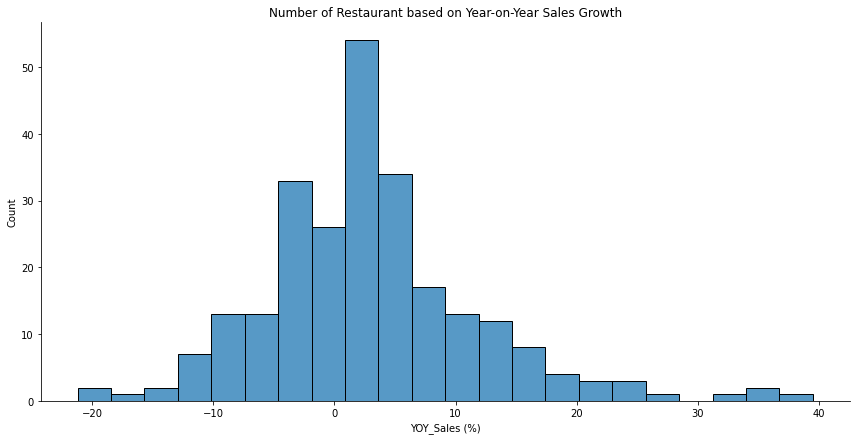

In [166]:
sns.displot(top_resto['YOY_Sales (%)'], height=6, aspect=2).set(title='Number of Restaurant based on Year-on-Year Sales Growth')

In [167]:
growth_sales_high = top_resto.nlargest(n=10, columns='YOY_Sales (%)').sort_values('YOY_Sales (%)', ascending=False)
growth_sales_high_choose = growth_sales_high[['Restaurant','Category', 'Segment', 'Adv Content Exist (1 = Yes, 0 = No)', 'Headquarters Exist (1 = Yes, 0 = No)', 'YOY_Sales (%)']]
print("Top 10 Highest Sale rate restaurant")
growth_sales_high_choose

Top 10 Highest Sale rate restaurant


,Restaurant,Category,Segment,"Adv Content Exist (1 = Yes, 0 = No)","Headquarters Exist (1 = Yes, 0 = No)",YOY_Sales (%)
214,Chicken Salad Chick,NaN,Chicken,1,0,39.5
200,Metro Diner,NaN,Family Style,0,0,36.3
81,First Watch,NaN,Family Dining & Family Style,0,0,35.1
70,Shake Shack,Fast Casual,Burger,0,0,31.8
235,Walk-On's Sports Bistreaux,NaN,Sports Bar,0,0,27.8
234,Mission BBQ,NaN,BBQ,0,0,25.0
41,Raising Cane's Chicken Fingers,Fast Casual,Chicken,0,0,23.8
92,MOD Pizza,Fast Casual,Pizza,0,0,23.8
76,Tropical Smoothie Cafe,Quick Service,Beverage,0,0,21.8
165,Lazy Dog Restaurant & Bar,NaN,Varied Menu,0,0,21.3


In [168]:
growth_sales_low = top_resto.nsmallest(n=10, columns='YOY_Sales (%)').sort_values('YOY_Sales (%)', ascending=True)
growth_sales_low_choose = growth_sales_low[['Restaurant', 'Segment', 'Category', 'Adv Content Exist (1 = Yes, 0 = No)', 'Headquarters Exist (1 = Yes, 0 = No)', 'YOY_Sales (%)']]
print("Top 10 Lowest Sale Growth restaurant")
growth_sales_low_choose

Top 10 Lowest Sale Growth restaurant


,Restaurant,Segment,Category,"Adv Content Exist (1 = Yes, 0 = No)","Headquarters Exist (1 = Yes, 0 = No)",YOY_Sales (%)
229,Houlihan's,Varied Menu,NaN,1,0,-21.2
230,Old Country Buffet/HomeTown Buffet,Family Casual,NaN,0,0,-18.8
182,Fuddruckers,Burger,NaN,0,0,-15.8
211,McCormick & Schmick's,Seafood,NaN,0,0,-15.6
167,Friendly's,Family Style,NaN,1,0,-15.3
171,Uno Pizzeria & Grill,Italian/Pizza,NaN,0,0,-12.9
143,Pei Wei Asian Diner,Asian/Noodle,NaN,0,1,-12.5
192,Taco Bueno,Mexican,NaN,0,0,-12.4
61,Ruby Tuesday,Varied Menu,Casual Dining,0,0,-11.4
245,Rainforest Cafe,Varied Menu,NaN,0,0,-10.4


In [169]:
# Calculate average YOY sales by segment
average_sales_by_segment = top_resto.groupby('Segment')['YOY_Sales (%)'].mean().round(1).reset_index()

# Sort by average sales in descending order for the top 10
top_10_segments = average_sales_by_segment.sort_values(by='YOY_Sales (%)', ascending=False).head(10)

# Sort by average sales in ascending order for the lowest 10
lowest_10_segments = average_sales_by_segment.sort_values(by='YOY_Sales (%)', ascending=True).head(10)

# Display the tables
print("Top 10 Segments:")
print(top_10_segments)

print("\nLowest 10 Segments:")
print(lowest_10_segments)

Top 10 Segments:
                Segment  YOY_Sales (%)
14              Healthy           16.8
8                Ethnic           11.9
4              Beverage           11.3
0                 Asian            7.8
6               Chicken            7.4
22                Steak            5.8
21           Sports Bar            5.1
16              Mexican            4.9
12  Fine Dining & Steak            4.7
7           Coffee Cafe            4.7

Lowest 10 Segments:
            Segment  YOY_Sales (%)
9     Family Casual           -6.5
15    Italian/Pizza           -0.4
13  Frozen Desserts           -0.4
19          Seafood           -0.1
23      Varied Menu            0.4
3       Bakery Cafe            0.6
2               BBQ            1.0
1      Asian/Noodle            1.3
11     Family Style            1.6
18         Sandwich            2.6


In [170]:
# Calculate average YOY sales by segment
average_sales_by_category = top_resto.groupby('Category')['YOY_Sales (%)'].mean().round(2).reset_index()

# Sort by average sales in descending order for the top 10
category_sales_growth = average_sales_by_category.sort_values(by='YOY_Sales (%)', ascending=False).head(10)

# Display the tables
print("Category Sales Growth")
print(category_sales_growth)

Category Sales Growth
        Category  YOY_Sales (%)
1    Fast Casual           9.85
2  Quick Service           3.43
0  Casual Dining           0.88


## Unit Growth

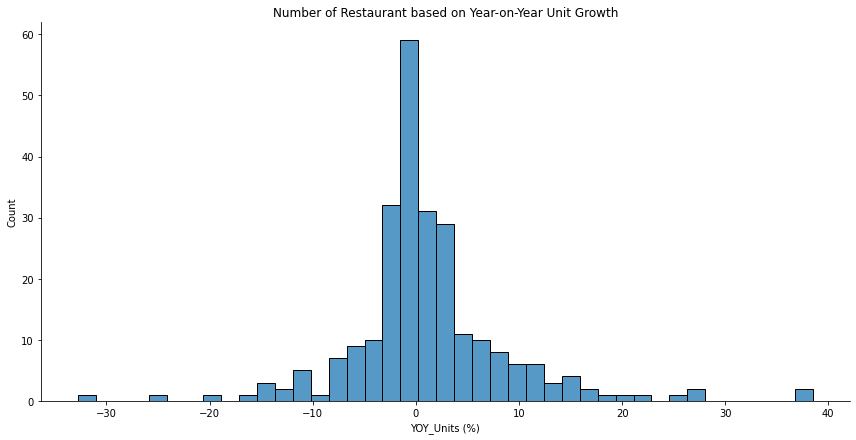

In [171]:
sns.displot(top_resto['YOY_Units (%)'], height=6, aspect=2).set(title='Number of Restaurant based on Year-on-Year Unit Growth')

In [172]:
growth_unit_high = top_resto.nlargest(n=10, columns='YOY_Units (%)').sort_values('YOY_Units (%)', ascending=False)
growth_unit_high_choose = growth_unit_high[['Restaurant', 'Segment', 'Category', 'Adv Content Exist (1 = Yes, 0 = No)', 'Headquarters Exist (1 = Yes, 0 = No)', 'YOY_Units (%)']]
print("Top 10 Highest Unit Growth restaurant")
growth_unit_high_choose

Top 10 Highest Unit Growth restaurant


,Restaurant,Segment,Category,"Adv Content Exist (1 = Yes, 0 = No)","Headquarters Exist (1 = Yes, 0 = No)",YOY_Units (%)
214,Chicken Salad Chick,Chicken,NaN,1,0,38.5
235,Walk-On's Sports Bistreaux,Sports Bar,NaN,0,0,37.5
178,True Food Kitchen,Varied Menu,NaN,1,0,28.0
70,Shake Shack,Burger,Fast Casual,0,0,27.2
81,First Watch,Family Dining & Family Style,NaN,0,0,24.7
234,Mission BBQ,BBQ,NaN,0,0,21.6
165,Lazy Dog Restaurant & Bar,Varied Menu,NaN,0,0,20.0
92,MOD Pizza,Pizza,Fast Casual,0,0,18.2
119,Cooper's Hawk Winery & Restaurants,Varied Menu,NaN,0,1,17.1
76,Tropical Smoothie Cafe,Beverage,Quick Service,0,0,16.0


In [173]:
growth_unit_low = top_resto.nsmallest(n=10, columns='YOY_Units (%)').sort_values('YOY_Units (%)', ascending=True)
growth_unit_low_choose = growth_unit_low[['Restaurant', 'Segment', 'Category', 'Adv Content Exist (1 = Yes, 0 = No)', 'Headquarters Exist (1 = Yes, 0 = No)', 'YOY_Units (%)']]
print("Top 10 Highest Unit Growth restaurant")
growth_unit_low_choose

Top 10 Highest Unit Growth restaurant


,Restaurant,Segment,Category,"Adv Content Exist (1 = Yes, 0 = No)","Headquarters Exist (1 = Yes, 0 = No)",YOY_Units (%)
229,Houlihan's,Varied Menu,NaN,1,0,-32.8
230,Old Country Buffet/HomeTown Buffet,Family Casual,NaN,0,0,-24.6
167,Friendly's,Family Style,NaN,1,0,-20.4
143,Pei Wei Asian Diner,Asian/Noodle,NaN,0,1,-16.7
211,McCormick & Schmick's,Seafood,NaN,0,0,-14.6
89,Boston Market,Chicken,Fast Casual,0,0,-14.1
171,Uno Pizzeria & Grill,Italian/Pizza,NaN,0,0,-14.1
82,Perkins Restaurant & Bakery,Family Dining & Family Style,NaN,1,0,-13.0
192,Taco Bueno,Mexican,NaN,0,0,-12.1
182,Fuddruckers,Burger,NaN,0,0,-11.5


In [174]:
# Calculate average YOY sales by segment
average_units_by_segment = top_resto.groupby('Segment')['YOY_Units (%)'].mean().round(2).reset_index()

# Sort by average sales in descending order for the top 10
top_10_segments = average_units_by_segment.sort_values(by='YOY_Units (%)', ascending=False).head(10)

# Sort by average sales in ascending order for the lowest 10
lowest_10_segments = average_units_by_segment.sort_values(by='YOY_Units (%)', ascending=True).head(10)

# Display the tables
print("Top 10 Segments:")
print(top_10_segments)

print("\nLowest 10 Segments:")
print(lowest_10_segments)

Top 10 Segments:
        Segment  YOY_Units (%)
14      Healthy          10.90
4      Beverage           7.40
8        Ethnic           6.90
21   Sports Bar           6.34
0         Asian           5.40
6       Chicken           3.09
7   Coffee Cafe           2.85
22        Steak           2.65
20        Snack           2.47
17        Pizza           1.88

Lowest 10 Segments:
                Segment  YOY_Units (%)
9         Family Casual          -7.74
11         Family Style          -2.52
1          Asian/Noodle          -2.52
13      Frozen Desserts          -1.13
15        Italian/Pizza          -0.85
19              Seafood          -0.68
2                   BBQ          -0.13
3           Bakery Cafe          -0.08
12  Fine Dining & Steak           0.00
23          Varied Menu           0.97


In [175]:
# Calculate average YOY sales by segment
average_units_by_category = top_resto.groupby('Category')['YOY_Units (%)'].mean().round(2).reset_index()

# Sort by average sales in descending order for the top 10
category_units_growth = average_units_by_category.sort_values(by='YOY_Units (%)', ascending=False).head(10)

print("Category Units Growth")
print(category_units_growth)

Category Units Growth
        Category  YOY_Units (%)
1    Fast Casual           5.65
2  Quick Service           0.94
0  Casual Dining           0.45


# Heatmap

## Numerize Category

In [176]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'Category' column
top_resto['Category_Encoded'] = label_encoder.fit_transform(top_resto['Category'])

In [177]:
top_resto.head()

,Rank,Restaurant,Content,Sales (Million USD),Units (pcs),Headquarters,"Adv Content Exist (1 = Yes, 0 = No)","Headquarters Exist (1 = Yes, 0 = No)",Category,Segment,YOY_Sales (%),YOY_Units (%),Sales per Units (Million USD),Category_Encoded
0,1,McDonald's,NaN,40412,13846,NaN,0,0,Quick Service,Burger,4.9,-0.5,2.92,2
1,2,Starbucks,NaN,21380,15049,NaN,0,0,Quick Service,Coffee Cafe,8.6,3.0,1.42,2
2,3,Chick-fil-A,While Popeyes got a lot of the chicken buzz in...,11320,2470,NaN,1,0,Quick Service,Chicken,13.0,5.0,4.58,2
3,4,Taco Bell,NaN,11293,6766,NaN,0,0,Quick Service,Mexican,9.0,2.7,1.67,2
4,5,Burger King,NaN,10204,7346,NaN,0,0,Quick Service,Burger,2.7,0.2,1.39,2


## Numerize Segmentation

In [178]:
# Encode the 'Category' column
top_resto['Segment_Encoded'] = label_encoder.fit_transform(top_resto['Segment'])

In [179]:
top_resto.head()

,Rank,Restaurant,Content,Sales (Million USD),Units (pcs),Headquarters,"Adv Content Exist (1 = Yes, 0 = No)","Headquarters Exist (1 = Yes, 0 = No)",Category,Segment,YOY_Sales (%),YOY_Units (%),Sales per Units (Million USD),Category_Encoded,Segment_Encoded
0,1,McDonald's,NaN,40412,13846,NaN,0,0,Quick Service,Burger,4.9,-0.5,2.92,2,5
1,2,Starbucks,NaN,21380,15049,NaN,0,0,Quick Service,Coffee Cafe,8.6,3.0,1.42,2,7
2,3,Chick-fil-A,While Popeyes got a lot of the chicken buzz in...,11320,2470,NaN,1,0,Quick Service,Chicken,13.0,5.0,4.58,2,6
3,4,Taco Bell,NaN,11293,6766,NaN,0,0,Quick Service,Mexican,9.0,2.7,1.67,2,16
4,5,Burger King,NaN,10204,7346,NaN,0,0,Quick Service,Burger,2.7,0.2,1.39,2,5


## Heatmap Plot

<AxesSubplot:>

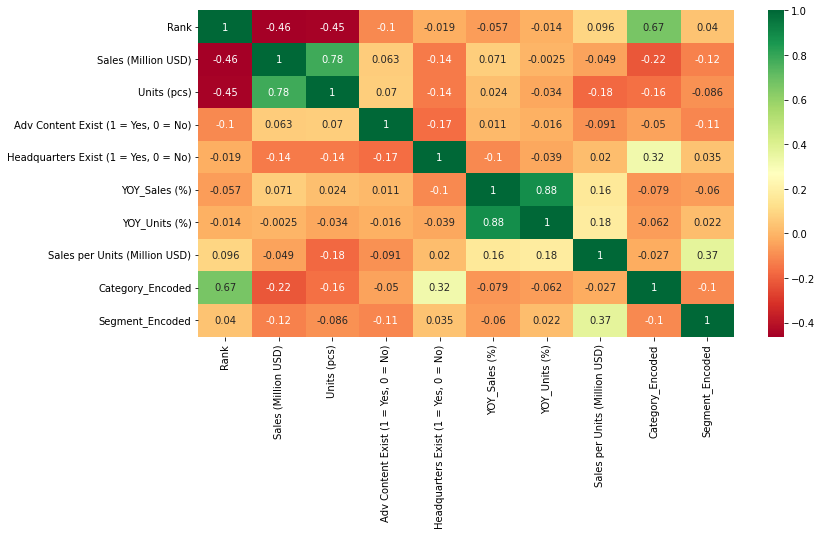

In [185]:
# Plot the heatmap
plt.figure(figsize=(12,6))
sns.heatmap(top_resto.corr(),annot=True, cmap="RdYlGn", annot_kws={"size":10})

# Conclusion

1. The advertisement content/slogan doesn't really work on growing your sales
2. There are some restaurant that depends on the unit number to add their sale rate, but some of them depends on the unit quality value (and choose to do not add their unit) to add their sale rate. This make their sale/unit values are high
3. Most of the restaurant with high unit and high sales are casual & fast-service restaurants.
4. Segment & category plays a little significant role on growing the sale rate and units number of the restaurant